# Explore Data

Метою цього проекту є розробка моделі машинного навчання, яка здатна прогнозувати ймовірність відставки співробітника з компанії. Модель буде навчатися на історичних даних і зможе робити прогнози на нові дані, що допоможе компанії ідентифікувати співробітників, які знаходяться в ризику відставки і приймати відповідні дії для їх утримання.

Розпочнімо з імпортування необхідних бібліотек та первинного аналізу наших даних.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
sns.set()

In [4]:
main_df = pd.read_csv('data.csv')
main_df

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure
0,221,engineering,NaN,0.932868,4,NaN,low,0.829896,Left,5.0
1,232,support,NaN,NaN,3,NaN,low,0.834544,Employed,2.0
2,184,sales,NaN,0.788830,3,NaN,medium,0.834988,Employed,3.0
3,206,sales,NaN,0.575688,4,NaN,low,0.424764,Employed,2.0
4,249,sales,NaN,0.845217,3,NaN,low,0.779043,Employed,3.0
...,...,...,...,...,...,...,...,...,...,...
14244,178,IT,NaN,0.735865,5,NaN,low,0.263282,Employed,5.0
14245,257,sales,NaN,0.638604,3,NaN,low,0.868209,Employed,2.0
14246,232,finance,1.0,0.847623,5,NaN,medium,0.898917,Left,5.0
14247,130,IT,NaN,0.757184,4,NaN,medium,0.641304,Employed,3.0


In [5]:
display(main_df.describe())
display(main_df.info())
display(main_df.department.value_counts())

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure
count,14249.000000,2058.0,12717.000000,14249.000000,300.0,14068.000000,14068.000000
mean,199.795775,1.0,0.718477,3.773809,1.0,0.621295,3.497228
std,50.998714,0.0,0.173062,1.253126,0.0,0.250469,1.460917
min,49.000000,1.0,0.316175,1.000000,1.0,0.040058,2.000000
25%,155.000000,1.0,0.563866,3.000000,1.0,0.450390,3.000000
50%,199.000000,1.0,0.724939,4.000000,1.0,0.652527,3.000000
75%,245.000000,1.0,0.871358,5.000000,1.0,0.824951,4.000000
max,310.000000,1.0,1.000000,7.000000,1.0,1.000000,10.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14249 entries, 0 to 14248
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_monthly_hrs    14249 non-null  int64  
 1   department         13540 non-null  object 
 2   filed_complaint    2058 non-null   float64
 3   last_evaluation    12717 non-null  float64
 4   n_projects         14249 non-null  int64  
 5   recently_promoted  300 non-null    float64
 6   salary             14249 non-null  object 
 7   satisfaction       14068 non-null  float64
 8   status             14249 non-null  object 
 9   tenure             14068 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 1.1+ MB


None

sales                     3923
engineering               2592
support                   2122
IT                        1161
product                    860
marketing                  819
finance                    728
management                 595
information_technology     209
temp                       181
admin                      176
procurement                174
Name: department, dtype: int64

In [6]:
n_employees = len(main_df)
display(main_df.status.value_counts())
display(main_df.status.value_counts()/n_employees*100)

Employed    10857
Left         3392
Name: status, dtype: int64

Employed    76.194821
Left        23.805179
Name: status, dtype: float64

# Cleaning

У стовпцях 'filed_complaint' та 'recently_promoted' заповнюємо пропущені значення 'NaN' на 0, оскільки відсутність даних означає відсутність негативної дії: наприклад, якщо значення 'filed_complaint' є NaN, то це означає, що скарги не було, тому заповнюємо його нулем (0). Аналогічно, якщо значення 'recently_promoted' є NaN, то це означає, що підвищення не було, тому заповнюємо його нулем (0).

Також змінюємо категоріальні дані номінального типу у стовпці 'status' на числові значення: 'Employed' - 0, а 'Left' - 1.

In [7]:
main_df.filed_complaint.fillna(0, inplace=True)
main_df.recently_promoted.fillna(0, inplace=True)
main_df.status.replace('Employed', 0, inplace=True)
main_df.status.replace('Left', 1, inplace=True)

В стопці "salary" також категоріальні дані з порядком, тому змінюємо їх.

In [8]:
display(main_df.salary.unique())
display(main_df.salary.value_counts())

array(['low', 'medium', 'high'], dtype=object)

low       6952
medium    6146
high      1151
Name: salary, dtype: int64

In [9]:
main_df.salary = main_df.salary.astype('category')
main_df.salary = main_df.salary.cat.reorder_categories(['low', 'medium', 'high'])
main_df.salary = main_df.salary.cat.codes


In [10]:
main_df.salary.value_counts()

0    6952
1    6146
2    1151
Name: salary, dtype: int64

In [11]:
main_df# перевіряємо чи все спрацювало

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure
0,221,engineering,0.0,0.932868,4,0.0,0,0.829896,1,5.0
1,232,support,0.0,NaN,3,0.0,0,0.834544,0,2.0
2,184,sales,0.0,0.788830,3,0.0,1,0.834988,0,3.0
3,206,sales,0.0,0.575688,4,0.0,0,0.424764,0,2.0
4,249,sales,0.0,0.845217,3,0.0,0,0.779043,0,3.0
...,...,...,...,...,...,...,...,...,...,...
14244,178,IT,0.0,0.735865,5,0.0,0,0.263282,0,5.0
14245,257,sales,0.0,0.638604,3,0.0,0,0.868209,0,2.0
14246,232,finance,1.0,0.847623,5,0.0,1,0.898917,1,5.0
14247,130,IT,0.0,0.757184,4,0.0,1,0.641304,0,3.0


Наступний крок - заповнення пропущених значень NaN у стовпцях 'tenure', 'satisfaction', 'last_evaluation'.
Аналізуючи відсутні дані в стовпцях 'tenure' та 'satisfaction', ми бачимо, що пропущені значення містяться тільки у департаменті 'temp'. 'Temp' є скороченням від 'temporary', (дані працивників які були прийняті на роботу на короткий термін або тимчасово) тобто для наших цілей ці працівники не мають значення. Крім того, зважаючи на те, що саме в цих рядках є пропущені дані, правильно та логічно заповнити їх буде вкрай важко (та й не потрібно).

In [12]:
nan_tenure = main_df[main_df['tenure'].isnull() & main_df['last_evaluation'].isnull() & main_df['satisfaction'].isnull()]
nan_tenure

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure
24,125,temp,0.0,NaN,2,0.0,1,NaN,0,NaN
28,67,temp,0.0,NaN,1,0.0,0,NaN,0,NaN
44,70,temp,0.0,NaN,3,0.0,0,NaN,0,NaN
252,81,temp,0.0,NaN,1,0.0,0,NaN,0,NaN
291,71,temp,0.0,NaN,2,0.0,0,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...
13850,95,temp,0.0,NaN,2,0.0,0,NaN,0,NaN
14083,123,temp,0.0,NaN,1,0.0,1,NaN,0,NaN
14105,81,temp,1.0,NaN,1,0.0,1,NaN,0,NaN
14126,132,temp,0.0,NaN,2,0.0,1,NaN,1,NaN


In [13]:
main_df = main_df[main_df['department'] != 'temp']# видаляємо працивників з департаменту "temp"
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14068 entries, 0 to 14248
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_monthly_hrs    14068 non-null  int64  
 1   department         13359 non-null  object 
 2   filed_complaint    14068 non-null  float64
 3   last_evaluation    12717 non-null  float64
 4   n_projects         14068 non-null  int64  
 5   recently_promoted  14068 non-null  float64
 6   salary             14068 non-null  int8   
 7   satisfaction       14068 non-null  float64
 8   status             14068 non-null  int64  
 9   tenure             14068 non-null  float64
dtypes: float64(5), int64(3), int8(1), object(1)
memory usage: 1.1+ MB


Далі працюємо зі стовпцем 'last_evaluation' та 'department'. Перша ідея, як заповнити NaN у стовпці 'last_evaluation', це розподілити їх по оцінкам відносно департаментів (перевірити, чи є закономірність між оцінками та департаментами, наприклад, серед адмінів повинні бути лише високі оцінки).

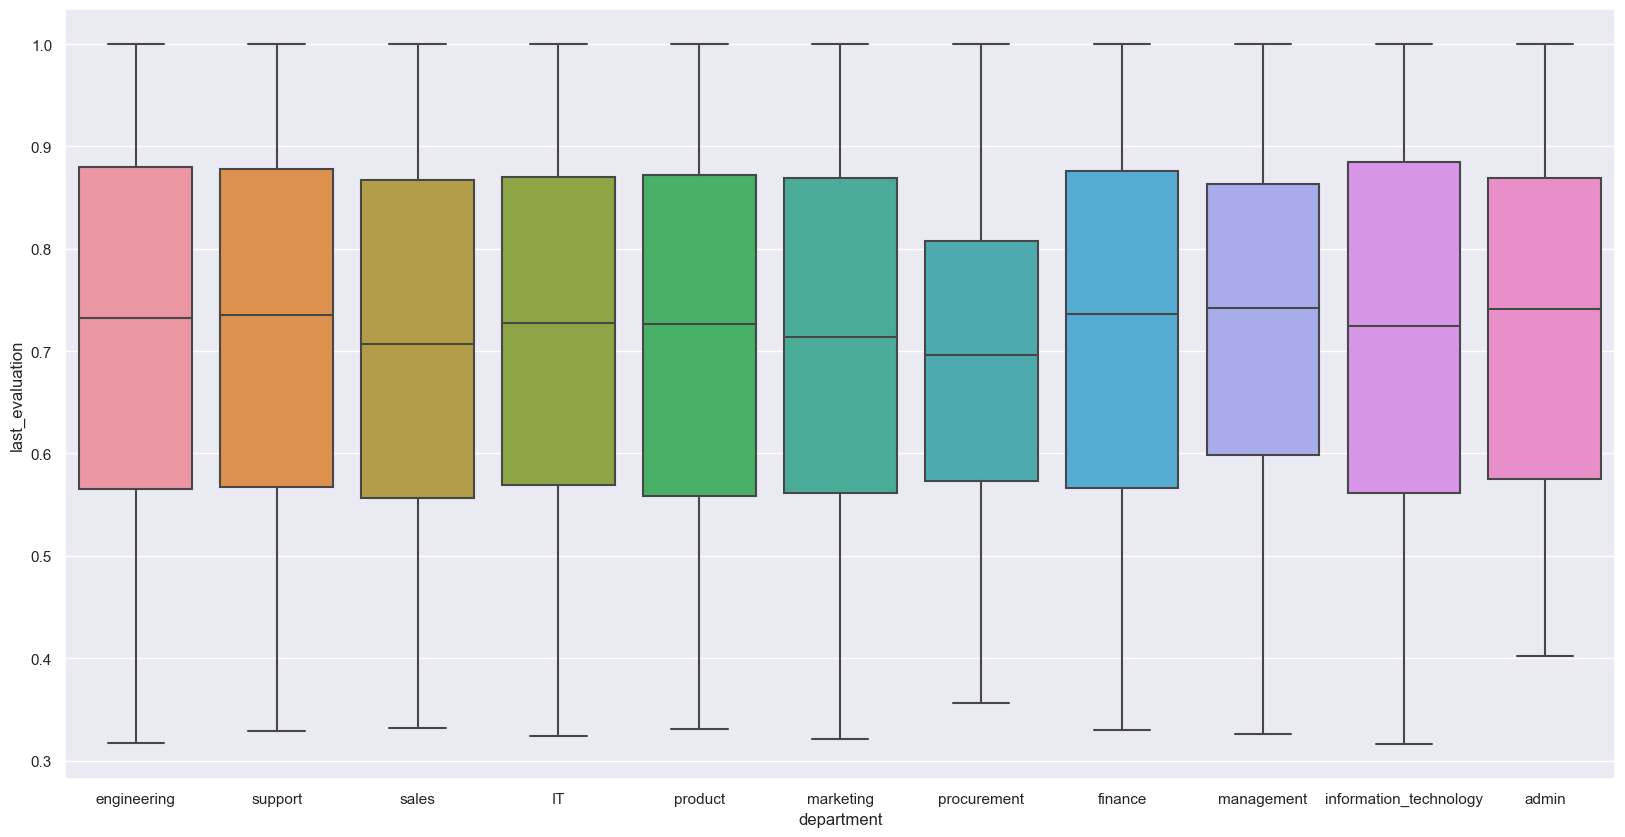

In [14]:
_ = plt.figure(figsize=(20, 10))
_ = sns.boxplot(x='department', y='last_evaluation', data=main_df)
_ = plt.ylabel('last_evaluation')
_ = plt.xlabel('department')
plt.show()

Здогадки не підтвердилися. Всі департаменти мають досить близькі показники в 'last_evaluation'.
Перевіримо і інші значення у таблиці pivot.

In [15]:
pivot_df = main_df.pivot_table(values=['last_evaluation', 'satisfaction', 'avg_monthly_hrs', 'tenure'], index='department', aggfunc=[np.mean, np.median]) 
pivot_df

mean                                         \
                       avg_monthly_hrs last_evaluation satisfaction    tenure   
department                                                                      
IT                          202.175711        0.720712     0.628324  3.481481   
admin                       201.272727        0.726282     0.611450  3.369318   
engineering                 202.469522        0.722332     0.617907  3.402392   
finance                     201.175824        0.723880     0.586787  3.543956   
information_technology      202.167464        0.716156     0.626717  3.315789   
management                  201.025210        0.729714     0.630428  4.294118   
marketing                   199.664225        0.715018     0.629122  3.567766   
procurement                 199.482759        0.699205     0.627930  3.264368   
product                     199.991860        0.719616     0.628774  3.487209   
sales                       200.842467        0.711254     0.623075  3.527148   
support                     200.975495        0.723200     0.626923  3.394910   

                                median                                      
                       avg_monthly_hrs last_evaluation satisfaction tenure  
department                                                                  
IT                               198.0        0.727363     0.666779    3.0  
admin                            196.0        0.740803     0.645048    3.0  
engineering                      201.0        0.732394     0.650585    3.0  
finance                          198.5        0.735929     0.611879    3.0  
information_technology           207.0        0.724781     0.630377    3.0  
management                       204.0        0.742450     0.654405    3.0  
marketing                        198.0        0.713747     0.652517    3.0  
procurement                      194.5        0.696037     0.670033    3.0  
product                          198.0        0.726919     0.657535    3.0  
sales                            201.0        0.706577     0.653309    3.0  
support                          201.0        0.735612     0.666912    3.0

Всі департаменти особливо не відрізняються один від одного. Лише кількістю працивників (наприклад продавців майже 4тис, а адмінів 174)

In [16]:
nan_department = main_df[main_df['department'].isnull()]# переглянемо дані працивників без департаментів
nan_department

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure
39,184,NaN,0.0,1.000000,5,0.0,0,0.297124,0,5.0
64,159,NaN,0.0,0.694101,3,0.0,0,0.556402,0,3.0
87,113,NaN,0.0,0.511794,4,0.0,0,0.632133,0,3.0
100,241,NaN,0.0,0.766545,3,0.0,0,0.851892,0,3.0
105,161,NaN,0.0,0.695098,2,0.0,1,0.611689,0,5.0
...,...,...,...,...,...,...,...,...,...,...
14166,263,NaN,0.0,0.937390,5,0.0,1,0.820062,1,5.0
14169,310,NaN,0.0,0.793898,7,0.0,0,0.111329,1,4.0
14200,191,NaN,1.0,0.484292,3,0.0,0,0.528702,0,2.0
14218,280,NaN,0.0,0.565752,3,0.0,1,0.493396,0,2.0


709 рядків з працівниками, які невідомо з якого департаменту. Видалити ці дані - нерентабельно, оскільки досить велика кількість даних. Рандомне розподілення цих 709 працівників по департаментах також не є варіантом, оскільки через високий розрив кількості працівників серед департаментів, це може значно підірвати достовірність даних. 
Тому було прийнято рішення зберегти ці дані, але записати їх у новий департамент під назвою "Anonymous". Так ми зберігаємо ці 709 записів та достовірність інших. Також варто уваги, що коефіцієнт ваги впливу на рішення залишитися в компанії чи звільнитися не надто впливає з якого департаменту працівник (в цьому ми переконаємося згодом).

In [17]:
main_df = main_df.reset_index(drop=True)
main_df.department.fillna('Anonymous', inplace=True)
main_df

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure
0,221,engineering,0.0,0.932868,4,0.0,0,0.829896,1,5.0
1,232,support,0.0,NaN,3,0.0,0,0.834544,0,2.0
2,184,sales,0.0,0.788830,3,0.0,1,0.834988,0,3.0
3,206,sales,0.0,0.575688,4,0.0,0,0.424764,0,2.0
4,249,sales,0.0,0.845217,3,0.0,0,0.779043,0,3.0
...,...,...,...,...,...,...,...,...,...,...
14063,178,IT,0.0,0.735865,5,0.0,0,0.263282,0,5.0
14064,257,sales,0.0,0.638604,3,0.0,0,0.868209,0,2.0
14065,232,finance,1.0,0.847623,5,0.0,1,0.898917,1,5.0
14066,130,IT,0.0,0.757184,4,0.0,1,0.641304,0,3.0


In [18]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14068 entries, 0 to 14067
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_monthly_hrs    14068 non-null  int64  
 1   department         14068 non-null  object 
 2   filed_complaint    14068 non-null  float64
 3   last_evaluation    12717 non-null  float64
 4   n_projects         14068 non-null  int64  
 5   recently_promoted  14068 non-null  float64
 6   salary             14068 non-null  int8   
 7   satisfaction       14068 non-null  float64
 8   status             14068 non-null  int64  
 9   tenure             14068 non-null  float64
dtypes: float64(5), int64(3), int8(1), object(1)
memory usage: 1003.0+ KB


In [19]:
# Конвертуєм категоріальні дані номінального типу з "department" в бінарні
main_dummy = pd.get_dummies(main_df, drop_first=True)
main_dummy

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure,department_IT,department_admin,department_engineering,department_finance,department_information_technology,department_management,department_marketing,department_procurement,department_product,department_sales,department_support
0,221,0.0,0.932868,4,0.0,0,0.829896,1,5.0,0,0,1,0,0,0,0,0,0,0,0
1,232,0.0,NaN,3,0.0,0,0.834544,0,2.0,0,0,0,0,0,0,0,0,0,0,1
2,184,0.0,0.788830,3,0.0,1,0.834988,0,3.0,0,0,0,0,0,0,0,0,0,1,0
3,206,0.0,0.575688,4,0.0,0,0.424764,0,2.0,0,0,0,0,0,0,0,0,0,1,0
4,249,0.0,0.845217,3,0.0,0,0.779043,0,3.0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14063,178,0.0,0.735865,5,0.0,0,0.263282,0,5.0,1,0,0,0,0,0,0,0,0,0,0
14064,257,0.0,0.638604,3,0.0,0,0.868209,0,2.0,0,0,0,0,0,0,0,0,0,1,0
14065,232,1.0,0.847623,5,0.0,1,0.898917,1,5.0,0,0,0,1,0,0,0,0,0,0,0
14066,130,0.0,0.757184,4,0.0,1,0.641304,0,3.0,1,0,0,0,0,0,0,0,0,0,0


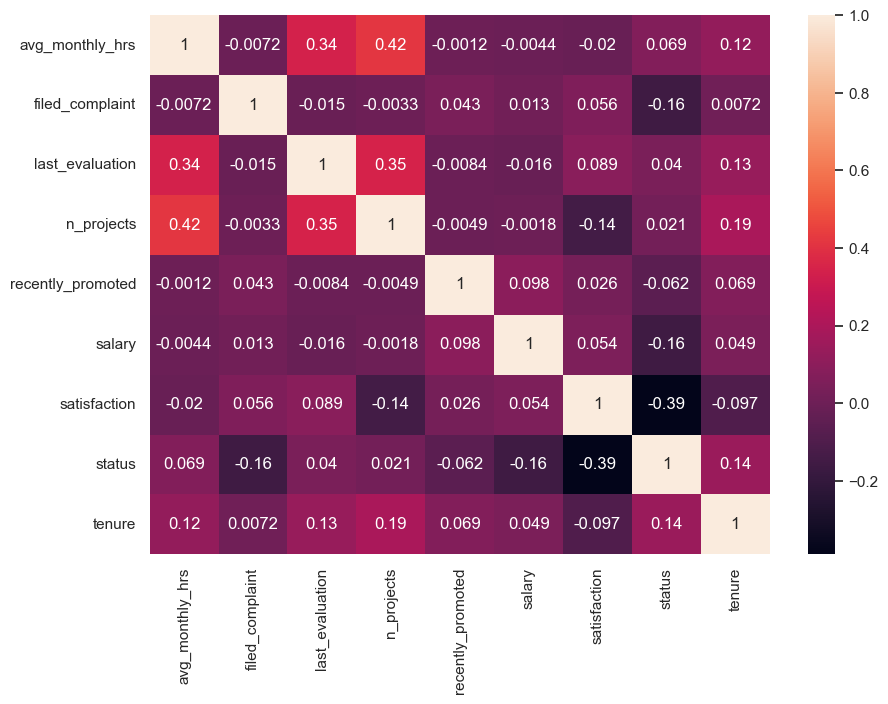

In [20]:
del_departm = main_df.drop('department', axis=1)# подивимся на кореляцію
corr_matrix = del_departm.corr()
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [ ]:
corr_matrix = main_dummy.corr()
plt.figure(figsize=(20, 7))
sns.heatmap(corr_matrix, annot=True)
plt.show()

Отже, що ми маємо. Ми спостерігаємо, що наш target (status) найбільше залежить від "satisfaction" (негативна кореляція, що означає, що чим менше показник задоволення, тим більша ймовірність, що працівник звільниться, тобто 'status' = 1). Але перед тим, як переходити до моделі з передбаченням target, потрібно заповнити NaN в "last_evaluation". Це можна зробити в конвеєрі Pipeline, використовуючи SimpleImputer зі стратегією заповнення середнім значенням. Але, оскільки це творча робота, в якій потрібно проявити свої знання, я прийняв рішення створити дві навчальні моделі: одну для змінної "last_evaluation" та іншу для target.

Перед початком побудови моделі для "last_evaluation", варто зазначити, що цей стовпець має найбільшу кореляцію з "avg_monthly_hrs" та "n_projects" (тобто чим більше проектів має працівник та чим більше він працює в середньому, тим вище його оцінка).

# ML for "last_evaluation"

In [21]:
# Видаляємо NaN рядки
evaluation_df = main_df.dropna(subset='last_evaluation')
# Конвертуєм категоріальні дані номінального типу з "department" в бінарні
evaluation_dummy = pd.get_dummies(evaluation_df, drop_first=True)

In [22]:
ev_nan = main_df[main_df['last_evaluation'].isnull()]# готуємо df для предікту NaN у "last_evaluation"
ev_data = ev_nan.drop("last_evaluation", axis=1)
ev_dum_pred = pd.get_dummies(ev_data, drop_first=True)# готовий df для предікту NaN у "last_evaluation"


Хід дій 
- готуємо датафрейми
- ділим дані на тестові та тренувальні (70/30)
- створюємо конвеєр Pipeline у якому здійснюємо стандартизацію даних (також ми вказуємо модель як один з етапів пайплайну, іншими словами "заглушка")
- обераємо декілька моделей та прописуємо гіперпараметри для кожної моделі
- за допопомогою GridSearchCV визначаємо найкращу модель з найкращими гіперпараметрами
- визначаємо модель та заповнюємо її даними (навчаємо)
- робимо предікт

In [23]:
X_ev = evaluation_dummy.drop("last_evaluation", axis=1)# всі дані без target ("last_evaluation")
y_ev = evaluation_dummy.last_evaluation# наш  target ("last_evaluation") в даній моделі

In [24]:
X_ev_train, X_ev_test, y_ev_train, y_ev_test = train_test_split(X_ev, y_ev, test_size= 0.3, random_state=42)

In [25]:
pipe = Pipeline([
    ('scaler', StandardScaler()),# здійснюємо стандартизацію даних
    ('model', LinearRegression())# модель-заглушка для Pipeline
])

param_grid = [
    {
        'model': [LinearRegression()],
        'model__normalize': [True, False]
    },
    {
        'model': [Lasso()],
        'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
    },
    {
        'model': [Ridge()],
        'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
    }
]

In [26]:
grid_ev = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid_ev.fit(X_ev_train, y_ev_train)

best_model_ev = grid_ev.best_estimator_
best_model_ev.fit(X_ev_train, y_ev_train)

D:\Anaconda\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardSca

Pipeline(steps=[('scaler', StandardScaler()), ('model', Lasso(alpha=0.001))])

Найкраща модель з гіперпараметрами -  Lasso(alpha=0.001)

In [27]:
y_ev_pred = best_model_ev.predict(X_ev_test)# оцінюємо модель

print(f"MSE: {mean_squared_error(y_ev_test, y_ev_pred)}")


MSE: 0.024080622029989576


In [28]:
evaluation_predict = best_model_ev.predict(ev_dum_pred)

Хоча модель не є ідеальною, вона все ж краща за заповнення 1400 рядків однаковим значенням.
Отже, настав час зробити предікт NaN значень у "last_evaluation"

In [29]:
evaluation_predict

array([0.7280963 , 0.5860524 , 0.61017544, ..., 0.62173435, 0.7239678 ,
       0.68421971])

In [30]:
ev_nan = ev_nan.reset_index(drop=True)
rest_df = main_df[~main_df['last_evaluation'].isnull()]
ev_nan.loc[:, 'last_evaluation'] = evaluation_predict
finish_df = pd.concat([rest_df, ev_nan])

In [31]:
finish_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14068 entries, 0 to 1350
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_monthly_hrs    14068 non-null  int64  
 1   department         14068 non-null  object 
 2   filed_complaint    14068 non-null  float64
 3   last_evaluation    14068 non-null  float64
 4   n_projects         14068 non-null  int64  
 5   recently_promoted  14068 non-null  float64
 6   salary             14068 non-null  int8   
 7   satisfaction       14068 non-null  float64
 8   status             14068 non-null  int64  
 9   tenure             14068 non-null  float64
dtypes: float64(5), int64(3), int8(1), object(1)
memory usage: 1.1+ MB


Оцінимо показники "last_evaluation" по "department"

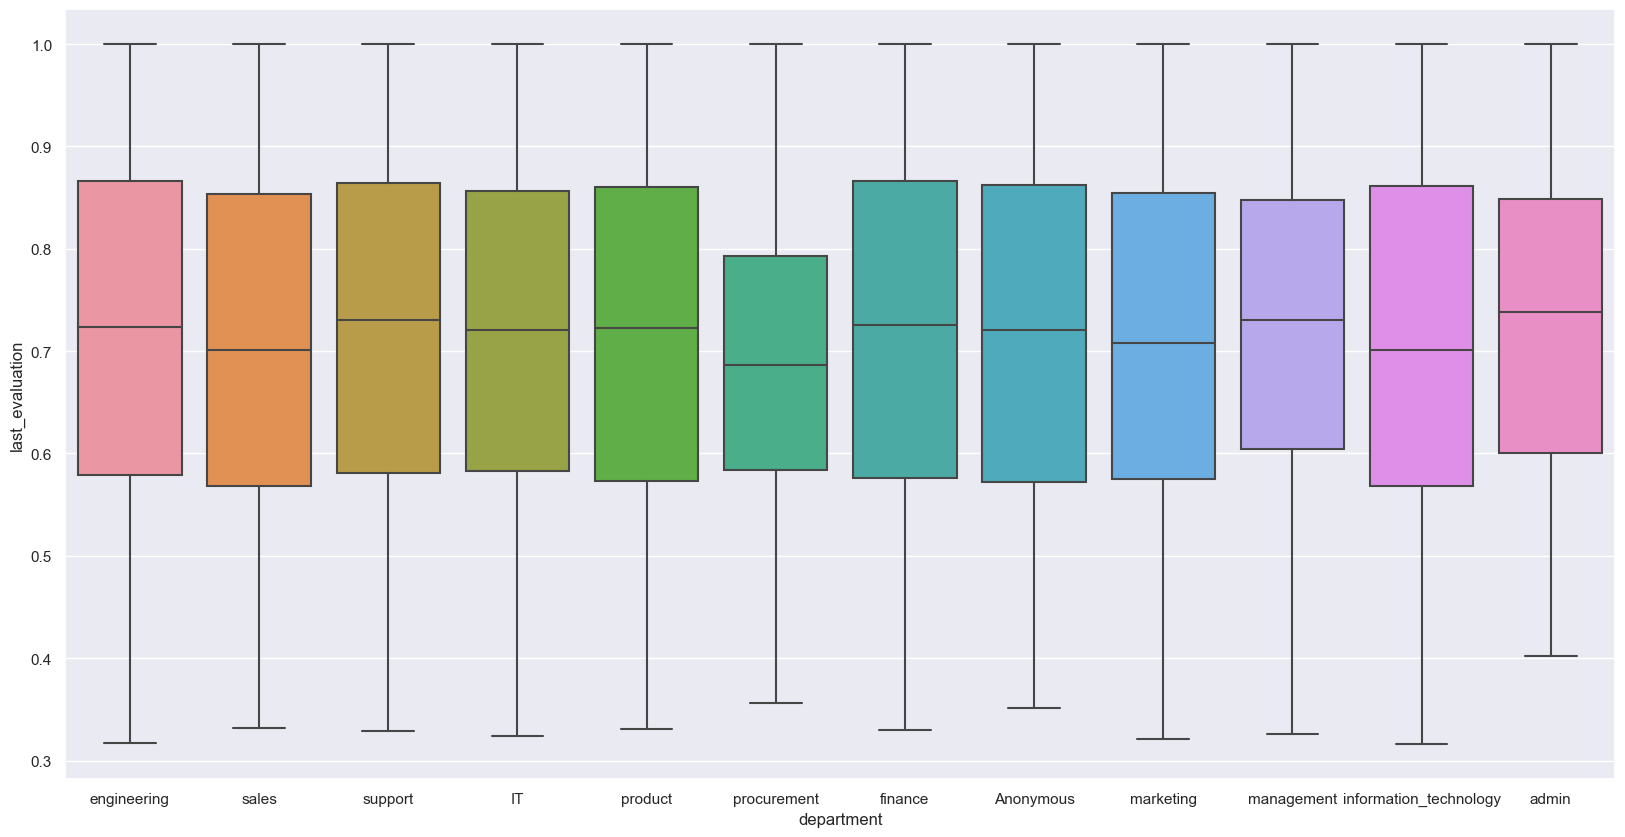

In [32]:
_ = plt.figure(figsize=(20, 10))
_ = sns.boxplot(x='department', y='last_evaluation', data=finish_df)
_ = plt.ylabel('last_evaluation')
_ = plt.xlabel('department')
plt.show()

Після успішного заповнення Nan у "last_evaluation", переходимо до кінцевої мети - предікт target "status"

# ML FOR TARGET


Хід дій залишається майже незмінним
- готуємо датафрейми
- ділим дані на тестові та тренувальні (70/30)
- створюємо конвеєр Pipeline у якому здійснюємо стандартизацію даних (також ми вказуємо модель як один з етапів пайплайну, іншими словами "заглушка")
- обераємо декілька моделей та прописуємо гіперпараметри для кожної моделі
- за допопомогою GridSearchCV визначаємо найкращу модель з найкращими гіперпараметрами
- визначаємо модель та заповнюємо її даними (навчаємо)
- оцінюємо модель

In [33]:
dummy = pd.get_dummies(finish_df, drop_first=True)

In [34]:
X = dummy.drop("status", axis=1)
y = dummy.status

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=42)

In [36]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

param_grid = [
    {
        'model': [LogisticRegression()],
        'model__C': [0.1, 1, 10]
    },
    {
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': [3, 5, 7],
        'model__weights': ['uniform', 'distance']
    },
    {
        'model': [DecisionTreeClassifier()],
        'model__max_depth': [2, 5, 10, None],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    }
]


In [37]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
best_model.fit(X_train, y_train)

D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avo

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 DecisionTreeClassifier(max_depth=10, min_samples_leaf=2,
                                        min_samples_split=5))])

Найкраща модель з гіперпараметрами -  DecisionTreeClassifier(max_depth=10, min_samples_leaf=2)

In [39]:
y_pred = best_model.predict(X_test)

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3196
           1       0.95      0.94      0.94      1025

    accuracy                           0.97      4221
   macro avg       0.96      0.96      0.96      4221
weighted avg       0.97      0.97      0.97      4221



Для класу 0 -'Employed' маємо precision 0.98, що означає, що 98% випадків, які класифікуються як 0 , насправді належать до класу 0. Recall для класу 0 дорівнює 0.99, що означає, що 99% випадків, які мають належати до класу 0, були правильно класифіковані. f1-score для класу 0 дорівнює 0.98, що є зваженою середньою точності і повноти.

Для класу 1 - 'Left' маємо precision 0.95, що означає, що 95% випадків, які класифікуються як 1, насправді належать до класу 1. Recall для класу 1 дорівнює 0.93, що означає, що 93% випадків, які мають належати до класу 1, були правильно класифіковані. f1-score для класу 1 дорівнює 0.94, що є зваженою середньою точності і повноти.

Загальна точність моделі (accuracy) дорівнює 0.97, що є дуже хорошим результатом.